In [ ]:
import pandas as pd
import plotly.express as px
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm  

---

# PLOT 1: BUBBLE CHART

---

From the dataset one, we need to extract: 
- % of total people with postmandatory studies in each neighborhood.
- % of inmigrants with postmandatory studies in each neighborhood.

In [9]:
# We read the dataset
df=pd.read_csv('generated_data/education_1997-2025.csv')

# We are interested on postmandatory studies, so let's define what they are
postmandatory_studies=['Upper secondary or post-secondary non-tertiary education', 'Tertiary education']

# Let's define inmigrants (out of Spain)
inmigrant_types=['Rest of European Union', 'Rest of World']

# Let's obtain the total population in each neighborhood
total_pop=df.groupby(['Year_Reference', 'District', 'Neighborhood'])['Value'].sum().reset_index()
total_pop.columns=['Year_Reference', 'District', 'Neighborhood', 'Total_Population']

# Let's obtain how many of these people have postmandatory studies
postmandatory=df[df['Education_Level'].isin(postmandatory_studies)] # We find the studies
postmandatory_total=postmandatory.groupby(['Year_Reference', 'District', 'Neighborhood'])['Value'].sum().reset_index() # We group by neighborhoods
postmandatory_total.columns=['Year_Reference', 'District', 'Neighborhood', 'Total_Postmandatory']

# Let's obtain the total inmigrants in each neighborhood
inmigrants=df[df['Birth_Place'].isin(inmigrant_types)] # We find the inmigrants
total_inmigrants=inmigrants.groupby(['Year_Reference', 'District', 'Neighborhood'])['Value'].sum().reset_index() # We group by neighborhoods
total_inmigrants.columns = ['Year_Reference', 'District', 'Neighborhood', 'Total_Inmigrants']

# Now, how many inmigrants have postmandatory studies
postmandatory_inmigrants=inmigrants[inmigrants['Education_Level'].isin(postmandatory_studies)] # We find the studies
postmandatory_inmigrants=postmandatory_inmigrants.groupby(['Year_Reference', 'District', 'Neighborhood'])['Value'].sum().reset_index() # We group by neighborhoods
postmandatory_inmigrants.columns=['Year_Reference', 'District', 'Neighborhood', 'Postmandatory_Inmigrants']

# Combine everything in the same DataFrame
percentages=total_pop.merge(postmandatory_total, on=['Year_Reference', 'District', 'Neighborhood'])
percentages=percentages.merge(postmandatory_inmigrants, on=['Year_Reference', 'District', 'Neighborhood'], how='left')
percentages=percentages.merge(total_inmigrants, on=['Year_Reference', 'District', 'Neighborhood'], how='left')

# Obtain percentages
percentages['Percentage_Postmandatory']=(percentages['Total_Postmandatory']/percentages['Total_Population'])*100
percentages['Percentage_Postmandatory_Inmigrants']=(percentages['Postmandatory_Inmigrants']/percentages['Total_Inmigrants'])*100

# Clean NaN from percentages: Refill with zero, the NaN is caused because there are no inmigrants
percentages['Percentage_Postmandatory_Inmigrants']=percentages['Percentage_Postmandatory_Inmigrants'].fillna(0)

# We save the dataset 
percentages.to_csv('generated_data/education_percentages_1997-2025.csv', index=False, encoding='utf-8')
percentages

,Year_Reference,District,Neighborhood,Total_Population,Total_Postmandatory,Postmandatory_Inmigrants,Total_Inmigrants,Percentage_Postmandatory,Percentage_Postmandatory_Inmigrants
0,1997,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",17854.0,5082.0,697.0,1728.0,28.464210,40.335648
1,1997,Ciutat Vella,el Barri Gòtic,12255.0,4054.0,554.0,1184.0,33.080375,46.790541
2,1997,Ciutat Vella,el Raval,30337.0,6067.0,1164.0,3542.0,19.998681,32.862789
3,1997,Ciutat Vella,la Barceloneta,13098.0,2089.0,184.0,543.0,15.949000,33.885820
4,1997,Eixample,Sant Antoni,32270.0,13088.0,728.0,1293.0,40.557794,56.303171
...,...,...,...,...,...,...,...,...,...
2112,2025,Sarrià-Sant Gervasi,Sant Gervasi - la Bonanova,22690.0,18493.0,4586.0,5722.0,81.502865,80.146802
2113,2025,Sarrià-Sant Gervasi,Sarrià,21032.0,16868.0,4107.0,5043.0,80.201598,81.439619
2114,2025,Sarrià-Sant Gervasi,"Vallvidrera, el Tibidabo i les Planes",4150.0,3010.0,862.0,1089.0,72.530120,79.155188
2115,2025,Sarrià-Sant Gervasi,el Putxet i el Farró,26503.0,21680.0,6522.0,7790.0,81.802060,83.722721


We can now continue with the representation, using this last csv and the one with the socioeconomic indices (Dataset 2).

In [10]:
from PIL import Image

# We create a folder to save the different plots
os.makedirs('outputs/results_plot1',exist_ok=True)

# We charge the datasets
percentages=pd.read_csv('generated_data/education_percentages_1997-2025.csv')
indices_df=pd.read_csv('generated_data/indices_2015-2022.csv')

# We create a plot for each year
years=[2015,2016,2017,2018,2019,2020,2021,2022]

for year in years:

    # Filter the datasets in the year we are interested in
    education_year=percentages[percentages['Year_Reference']==year]
    indices_year=indices_df[indices_df['año']==year]

    # Combine the datasets
    df_combined=education_year.merge(
        indices_year,
        left_on='Neighborhood',
        right_on='barrios de Barcelona',
    )

    # Create the plot
    fig=px.scatter(
            df_combined, 
            x="extranjeros de países de renta baja o media (%)",  
            y="renta media por persona (€)",         
            size="Percentage_Postmandatory",          
            color="Percentage_Postmandatory_Inmigrants",  
            hover_name="Neighborhood",                
            hover_data={
                'Total_Population': ':,',             
                'Total_Inmigrants': ':,',             
                'Percentage_Postmandatory': ':.1f',   
                'District': True                      
            },
            color_continuous_scale="Viridis",        
            trendline="lowess"
    )   

    # We want to mark the relevant neighborhoods: let's adjust the arrows and names
    neighborhoods1=["les Tres Torres"]
    neighborhoods2=["Ciutat Meridiana", "el Raval"]
    neighborhoods3=["la Dreta de l'Eixample"]
    neighborhoods4=["el Barri Gòtic"]

    for nei in neighborhoods1:
        nei_data = df_combined[df_combined['barrios de Barcelona'] == nei]
        if not nei_data.empty:
            fig.add_annotation(
                x=nei_data["extranjeros de países de renta baja o media (%)"].iloc[0],
                y=nei_data["renta media por persona (€)"].iloc[0],
                text=nei,
                showarrow=True,
                arrowhead=2,     
                arrowsize=1,     
                arrowwidth=1,    
                arrowcolor="black",  
                ax=15,              
                ay=-30,
                yshift=5,  
                font=dict(size=12, color="black", family="Arial")
            )
    for nei in neighborhoods2:
        nei_data = df_combined[df_combined['barrios de Barcelona'] == nei]
        if not nei_data.empty:
            fig.add_annotation(
                x=nei_data["extranjeros de países de renta baja o media (%)"].iloc[0],
                y=nei_data["renta media por persona (€)"].iloc[0],
                text=nei,
                showarrow=True,
                arrowhead=2,     
                arrowsize=1,     
                arrowwidth=1,    
                arrowcolor="black",  
                ax=10,              
                ay=30,
                yshift=-5,  
                font=dict(size=12, color="black", family="Arial")
            )
    for nei in neighborhoods3:
        nei_data = df_combined[df_combined['barrios de Barcelona'] == nei]
        if not nei_data.empty:
            fig.add_annotation(
                x=nei_data["extranjeros de países de renta baja o media (%)"].iloc[0],
                y=nei_data["renta media por persona (€)"].iloc[0],
                text=nei,
                showarrow=True,
                arrowhead=2,     
                arrowsize=1,     
                arrowwidth=1,    
                arrowcolor="black",  
                ax=70,              
                ay=-30,
                yshift=5,  
                font=dict(size=12, color="black", family="Arial")
            )
    for nei in neighborhoods4:
        nei_data = df_combined[df_combined['barrios de Barcelona'] == nei]
        if not nei_data.empty:
            fig.add_annotation(
                x=nei_data["extranjeros de países de renta baja o media (%)"].iloc[0],
                y=nei_data["renta media por persona (€)"].iloc[0],
                text=nei,
                showarrow=True,
                arrowhead=2,     
                arrowsize=1,     
                arrowwidth=1,    
                arrowcolor="black",  
                ax=-15,              
                ay=-40,
                yshift=5,  
                font=dict(size=12, color="black", family="Arial")
            )

    # Configuration of the visualization

    fig.update_traces(
        line=dict(color="black", width=2),
    )

    fig.update_coloraxes(cmin=35, cmax=85)  

    fig.update_layout(
        xaxis=dict(
            title="Foreigners from low- or middle-income countries (%)",
            title_font=dict(size=17, family="Arial", color="black", weight="bold"),
            tickfont=dict(size=14),
            range=[0, 45]
        ),
        yaxis=dict(
            title="Average income per person (€)",
            title_font=dict(size=17, family="Arial", color="black" , weight="bold"),
            tickfont=dict(size=14),
            range=[0, 40000]
        ),
        width=700,
        height=500,
        margin=dict(l=100, r=200, t=100, b=100),
        coloraxis_colorbar=dict(
            title=dict(
                text="Inmigrants with post-compulsory studies (%)",
                side="top",
                font=dict(size=17, family="Arial", color="black", weight="bold"),
            ),
          
            tickfont=dict(family="Arial", size=14, color="black"),
            orientation="h",
            x=0.5,
            xanchor="center",
            y=1.3,
            yanchor="top",
            thickness=20,
            len=1
        )
    )

    # Let's add a personalized legend for the size of the circles
    img = Image.open("images/legend.png")

    fig.add_layout_image(
        dict(
            source=img,
            xref="paper",
            yref="paper",
            x=1.03,     
            y=0.79,      
            sizex=0.6,  
            sizey=0.6,  
            xanchor="left",
            yanchor="top"
        )
    )

    # Let's add the year in each plot
    fig.add_annotation(
        x=0.95,
        y=0.95,
        xref="paper",
        yref="paper",
        text=f"{year}",
        showarrow=False,
        font=dict(size=16, color="black")
    )

    #fig.show()

    # Save the image in the folder
    fig.write_image(f'outputs/results_plot1/plot1_{year}.png', scale=3)

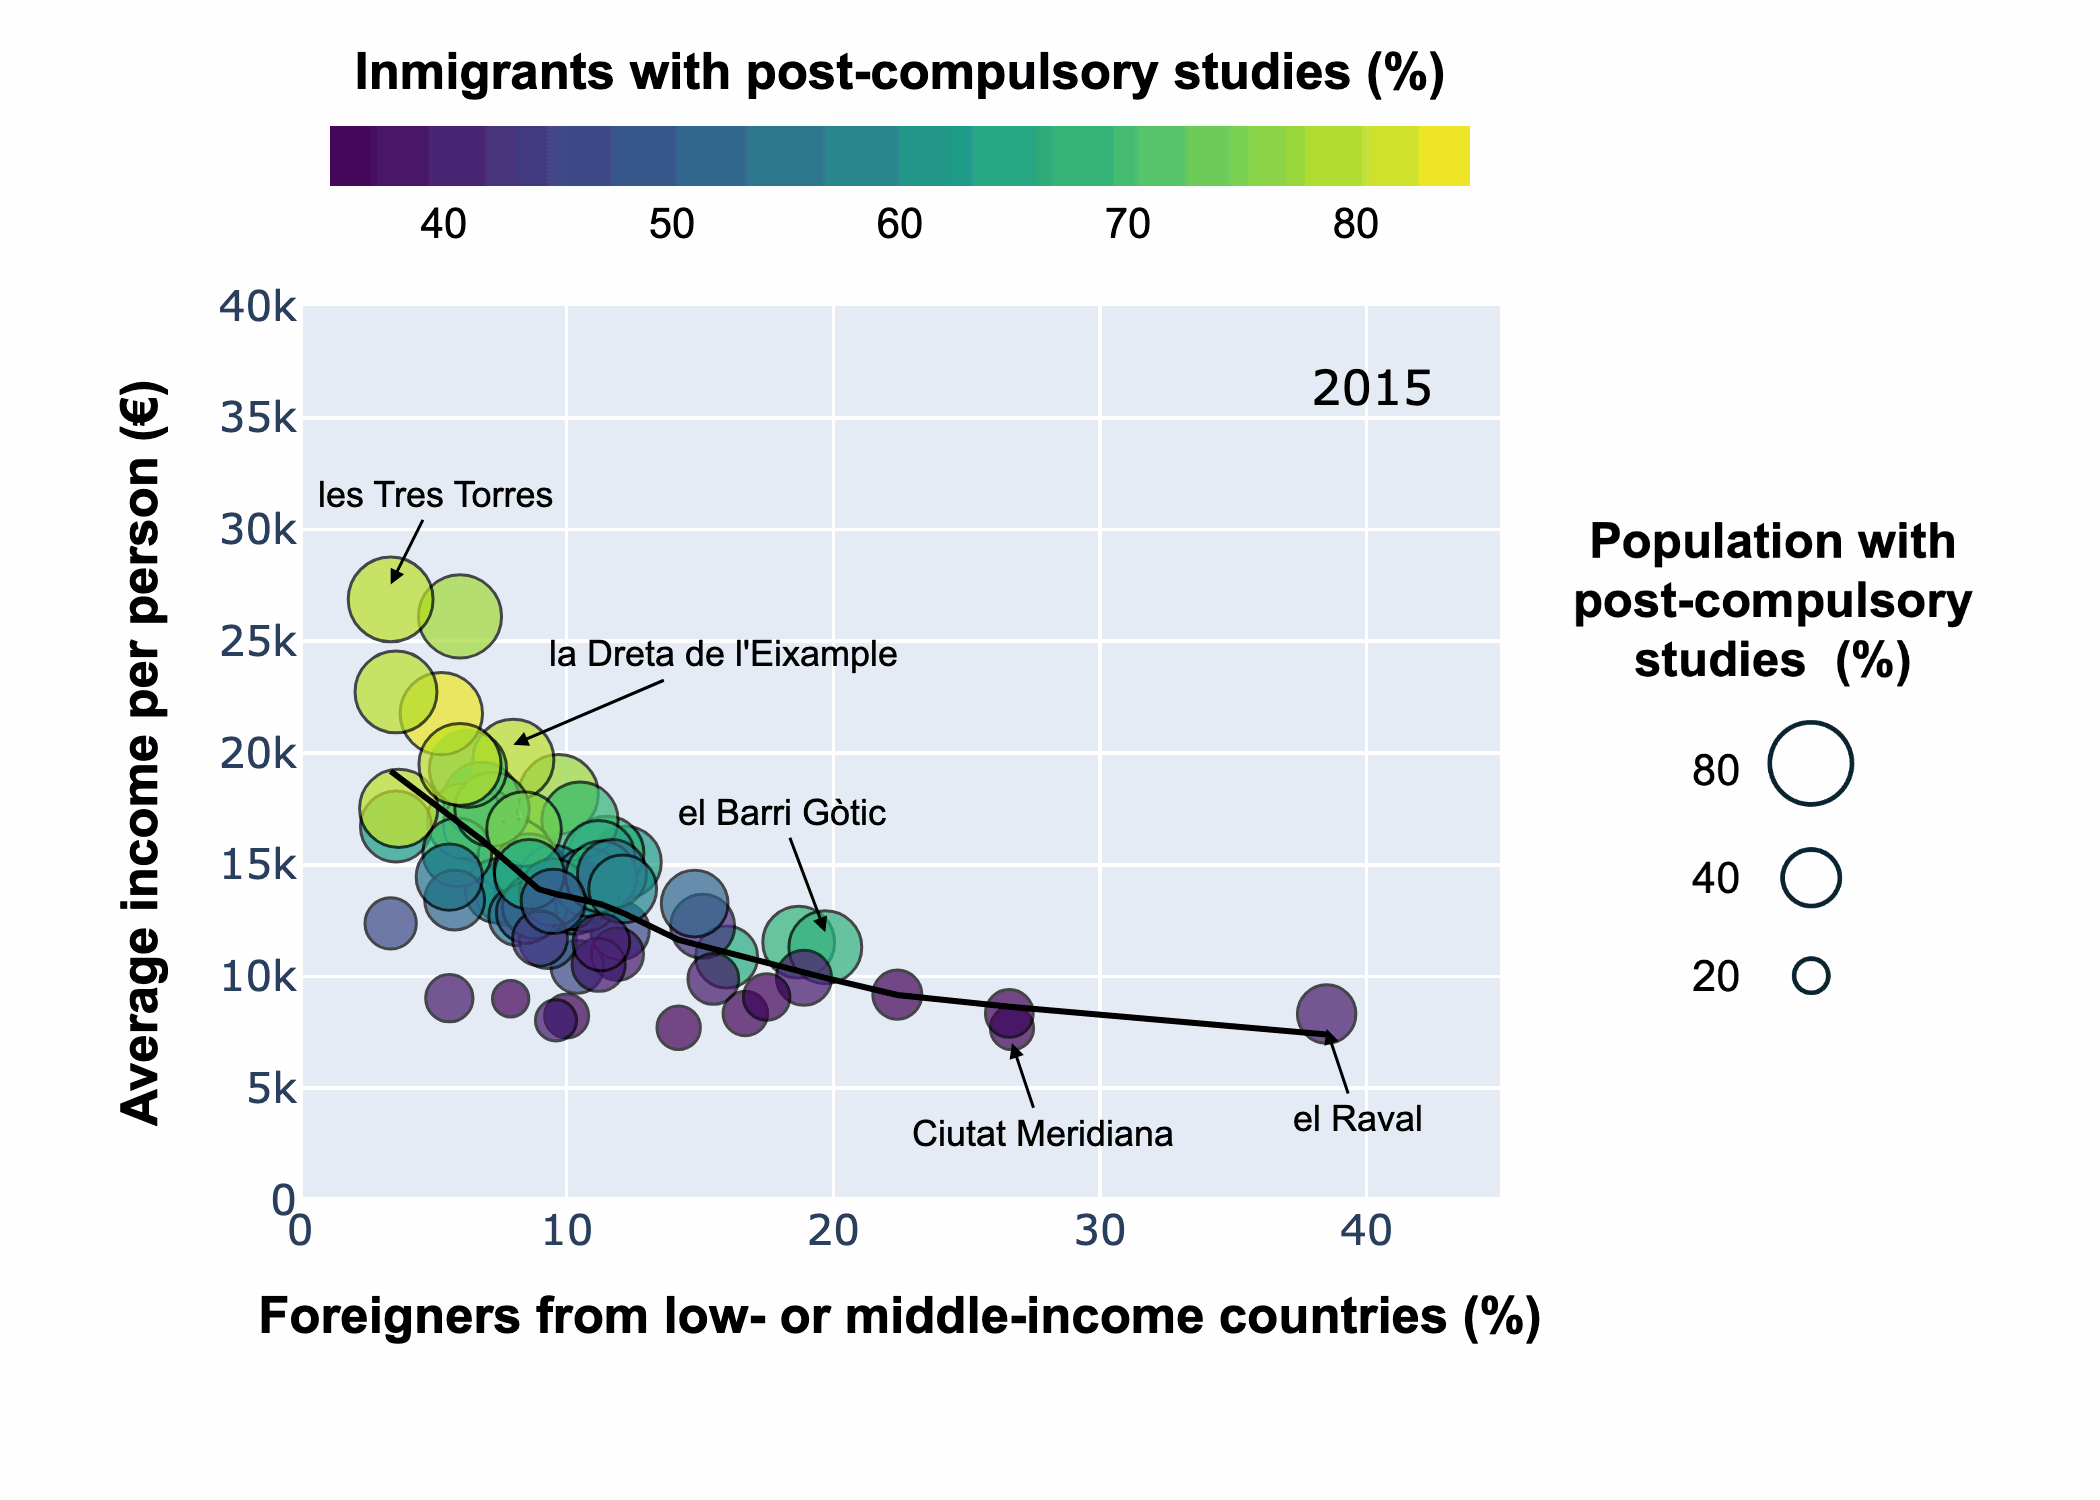

In [11]:
from PIL import Image

# We create a gif over the years
frames_dir="outputs/results_plot1"
files=sorted([f for f in os.listdir(frames_dir) if f.endswith(".png")])
frame_files=[os.path.join(frames_dir, f) for f in files]

frames=[Image.open(f) for f in frame_files]

frames[0].save(
    "outputs/plot1.gif",
    save_all=True,
    append_images=frames[1:],
    duration=500,   
    loop=0
)

from IPython.display import Image, display

display(Image(filename="outputs/plot1.gif"))

Instead of doing a gif we can plot 4 of the years to see the evolution:

In [15]:
from PIL import Image

years_to_plot = [2016, 2018, 2020, 2022]
positions = [(1,1), (1,2), (2,1), (2,2)]

# Barrios a anotar
neighborhoods1 = ["les Tres Torres"]
neighborhoods2 = ["Ciutat Meridiana", "el Raval"]
neighborhoods3 = ["la Dreta de l'Eixample"]
neighborhoods4 = ["el Barri Gòtic"]

# Crear subplots 2x2
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[str(year) for year in years_to_plot],
    horizontal_spacing=0.1,
    vertical_spacing=0.15
)

# Coloraxis compartido con Viridis
coloraxis_dict = dict(
    cmin=35,
    cmax=85,
    colorbar=dict(
        title=dict(
            text="Inmigrants with post-compulsory studies (%)",
            side="top",
            font=dict(color="black")
        ),
        orientation="h",
        x=0.225,
        xanchor="center",
        y=-0.262,
        yanchor="bottom",
        thickness=20,
        len=0.5
    ),
    colorscale="Viridis"
)

for year, (row, col) in zip(years_to_plot, positions):
    education_year = percentages[percentages['Year_Reference']==year]
    indices_year = indices_df[indices_df['año']==year]

    df_combined = education_year.merge(
        indices_year,
        left_on='Neighborhood',
        right_on='barrios de Barcelona'
    )

    # Scatter de puntos
    scatter = go.Scatter(
        x=df_combined["extranjeros de países de renta baja o media (%)"],
        y=df_combined["renta media por persona (€)"],
        mode='markers',
        marker=dict(
            size=df_combined["Percentage_Postmandatory"],
            color=df_combined["Percentage_Postmandatory_Inmigrants"],
            coloraxis="coloraxis",
            sizemode='area',
            sizeref=2.*max(df_combined["Percentage_Postmandatory"])/(25.**2),
            sizemin=3,
            line=dict(width=1, color='black')
        ),
        hovertemplate=(
            "<b>%{text}</b><br>" +
            "Foreigners (%): %{x:.1f}<br>" +
            "Income (€): %{y:,.0f}<br>" +
            "Postmandatory (%): %{marker.size:.1f}<extra></extra>"
        ),
        text=df_combined["Neighborhood"]
    )
    fig.add_trace(scatter, row=row, col=col)

    # Línea de tendencia LOWESS
    x = df_combined["extranjeros de países de renta baja o media (%)"]
    y = df_combined["renta media por persona (€)"]
    lowess = sm.nonparametric.lowess(y, x, frac=0.6)
    trend = go.Scatter(
        x=lowess[:,0],
        y=lowess[:,1],
        mode='lines',
        line=dict(color='black', width=2),
        showlegend=False
    )
    fig.add_trace(trend, row=row, col=col)

    # Anotaciones con flechas personalizadas por grupo
    groups = [
        (neighborhoods1, 15, -30),
        (neighborhoods2, 10, 30),
        (neighborhoods3, 70, -30),
        (neighborhoods4, -15, -40)
    ]

    for neighborhoods, ax_val, ay_val in groups:
        for nei in neighborhoods:
            nei_data = df_combined[df_combined['barrios de Barcelona'] == nei]
            if not nei_data.empty:
                fig.add_annotation(
                    x=nei_data["extranjeros de países de renta baja o media (%)"].iloc[0],
                    y=nei_data["renta media por persona (€)"].iloc[0],
                    text=nei,
                    showarrow=True,
                    arrowhead=2,
                    arrowsize=1,
                    arrowwidth=1,
                    arrowcolor="black",
                    ax=ax_val,
                    ay=ay_val,
                    font=dict(size=10, color="black"),
                    row=row, col=col
                )

    # Ejes
    fig.update_xaxes(title="Foreigners from low- or middle-income countries (%)", row=row, col=col, color='black')
    fig.update_yaxes(title="Average income per person (€)", row=row, col=col, color='black')

# Añadir imagen de la leyenda
img = Image.open("images/legend3.png")
fig.add_layout_image(
    dict(
        source=img,
        xref="paper",
        yref="paper",
        x=0.56,       # posición horizontal (fuera de los subplots)
        y=-0.14,       # posición vertical
        sizex=0.42,    # ancho
        sizey=0.42,    # alto
        xanchor="left",
        yanchor="top",
        layer="above"
    )
)

# Layout general
fig.update_layout(
    coloraxis=coloraxis_dict,
    width=1000,
    height=900,
    showlegend=False,
    margin=dict(l=100, r=100, t=100, b=200)
)

fig.show()
fig.write_image(f'outputs/plot1.png', scale=3)
